In [1]:
import glob
import pickle
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family']='Helvetica'
plt.rcParams['font.size']=14

In [2]:
from keras.models import Model, Sequential
from keras.layers import Conv1D,LSTM,Bidirectional,GRU,Input,Dropout,BatchNormalization,Reshape,Activation
from keras.layers import UpSampling1D,UpSampling2D, Conv2D,TimeDistributed,Dense
from keras.optimizers import Adam


Using TensorFlow backend.
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda2/envs/seismo/lib/python3.7/sit

In [3]:
def generate_gaussian(mean,std=10,length=30000):
    x_values = np.arange(0,length)
    y_values = scipy.stats.norm(mean,std)
    y_values = y_values.pdf(x_values)
    #re-escale to peak at one
    y_values = y_values/np.max(y_values)
    # truncate at 2 sigmas
    y_truncated = np.zeros((30000))
    y_truncated[int(mean-2*std):int(mean+2*std)] = y_values[int(mean-2*std):int(mean+2*std)]
    
    return y_values,y_truncated

def generate_box(index1,index2,length=30000):
    y_label = np.zeros((length))
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def generate_box_short(index1,index2,length=996):
    y_label = np.zeros((length))
    index1 = int(index1/30)
    index2 = int(index2/30)
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def plot_spectrogram(seismogram):
    # pass one channel at a time and fix the window values
    fs   = 100
    nfft = 128
    noverlap = 98
    spectrum,freqs,bins,im = plt.specgram(seismogram,nfft,fs,noverlap=noverlap,cmap='jet')
    return spectrum

def create_spec_one(data):
    x = plot_spectrogram(data['data'][-1])
    x = np.expand_dims(x,axis=0)
    return x

def create_spec_three(data):
    X = []
    for i in range(len(data['data'])):
        x = plot_spectrogram(data['data'][i])
        x = np.expand_dims(x,axis=0)
        X.append(x)
        # concatenate the matrices
    X = np.concatenate(X,axis=0)
    return X



def create_training_example(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    x     = data['data']
    y = np.zeros((5,30000))
    # check if the initial phase is Pg or Pn
    if data['Pn']!=0:
        box  = generate_box(data['Pn'],data['Sn'])
        _, y_pn = generate_gaussian(mean=data['Pn'])
        
    if data['Pg']!=0:
        box  = generate_box(data['Pg'],data['Sg'])
        _, y_pg = generate_gaussian(mean=data['Pg'])
        
    if data['Pn']==0:
        y_pn = np.zeros(30000)   
    if data['Pg']==0:
        y_pg = np.zeros(30000)
        
        
    if data['Sn']==0:
        y_sn = np.zeros(30000)
    if data['Sn']!=0:
        _, y_sn = generate_gaussian(mean=data['Sn'])
    
    if data['Sg']==0:
        y_sg = np.zeros(30000)
    if data['Sg']!=0:
        _,y_sg = generate_gaussian(mean=data['Sg'])
    
    #y = (box,y_pg,y_pn,y_sg,y_sn)
    
    y[0,:] = box; y[1,:] = y_pg; y[2,:] = y_pn; y[3,:] = y_sg; y[4,:] = y_sn;
    
        
    return x,y


def create_training_example_spec(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    
    if data['Pn']!=0:
        box  = generate_box_short(data['Pn'],data['Sn'])
        
    if data['Pg']!=0:
        box  = generate_box_short(data['Pg'],data['Sg'])
        
    # generate the spectrogram using just one component
    x = create_spec_one(data)
    y = box
    
    return x,y


def plot_example(x,y):
    plt.figure(figsize=(15,6)) 
    components = ['E','N','Z']
    for i in range(x.shape[0]):
        plt.subplot(3,1,i+1)
        
        plt.plot(x[i,:],c='k',linewidth=0.3,alpha=0.5)
        plt.plot(y[0,:],label='box')
        plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
        plt.text(1000,0.5,components[i],fontsize=18)
        
        plt.xlim(0,30000)
        plt.legend(loc='upper right',fontsize=13)
        
        
def load_multiple(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    filenames = glob.glob('data*pkl')
    randint = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]
    # initialize tensors
    X = np.zeros((m,3,30000))
    Y = np.zeros((m,5,30000))
    #Y_spec = np.zeros((m,996))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example(filename)
        X[i,:,:]   = x
        Y[i,:,:]   = y
    return X,Y


def load_multiple_spec(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    
    filenames = glob.glob('data*pkl')
    randint = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]
    
    # initialize tensors
    X = np.zeros((m,65,996))
    Y = np.zeros((m,996))
    #Y_spec = np.zeros((m,996))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example_spec(filename)
        X[i,:,:]   = x
        Y[i,:]   = y
    return X,Y


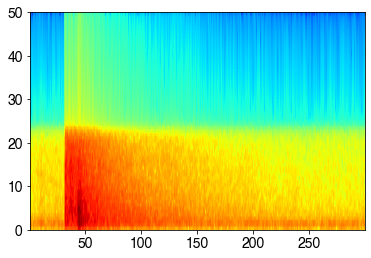

In [5]:
X_train_spec,Y_train_spec = load_multiple_spec(10)

In [ ]:
X_train_spec.shape

In [ ]:
x2,y2 = create_training_example_spec('data__Pn_3016.pkl')

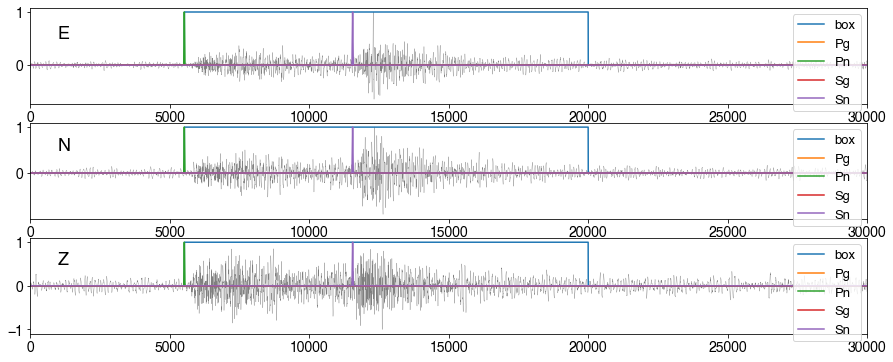

In [6]:
x1,y1 = create_training_example('data__Pn_3016.pkl')
plot_example(x1,y1)

In [ ]:
X_train,Y_train = load_multiple(300)

X_train = np.swapaxes(X_train,1,2)
Y_train = np.swapaxes(Y_train,1,2)
print(X_train.shape,Y_train.shape)

In [ ]:
Y_train = Y_train[:,2,:]  # this gives the Pn label 
# access the labels in this order:
# 0 -> box
# 1 -> pg
# 2 -> pn
# 3 -> sg
# 4 -> sn

In [ ]:
Y_train.shape

In [ ]:
def model(input_shape):
    
    
    X_input=Input(shape=input_shape)
    
    # A convolutional block
    X = Conv1D(filters=32,kernel_size=5,strides=2,padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.8)(X)
    
    # 
    X = Conv1D(filters=15,kernel_size=5,strides=2,padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.8)(X)
    
    X = Conv1D(filters=5,kernel_size=5,strides=2,padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.8)(X)
    
    
    # Up Sampling
    #X = UpSampling1D(size=2)(X)
    
    #X = UpSampling1D(size=2)(X)
    
    #X = UpSampling1D(size=2)(X)
    
    
    
    model = Model(inputs=X_input,outputs=X)
    
    return model

In [ ]:
#model = model(input_shape=(X_train.shape[0],X_train.shape[1]))
model = model(input_shape=(30000,3))

In [ ]:
model.summary()

In [ ]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["binary_crossentropy"])

In [ ]:
model.fit(X_train,Y_train,batch_size=8,epochs=10)

In [ ]:
# make predictions and plot them
X_pred,Y_pred = load_multiple(10)
X_pred = np.swapaxes(X_pred,1,2)

In [ ]:
predictions = model.predict(X_pred)

In [ ]:
predictions.shape

In [ ]:
X_pred.shape

In [ ]:
plt.close()
plt.plot(X_pred[1,:,0])
plt.plot(predictions[1,:,0])


# Using spectrograms

In [ ]:
X_spec_train.shape
X_spec_train = np.swapaxes(X_spec_train,1,2)
X_spec_train.shape

In [4]:

def model(input_shape):
    
    X_input = Input(shape=input_shape)
    
    # Convoultion layer
    X = Conv1D(filters=128,strides=1,kernel_size=16,padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM
    X = Bidirectional(LSTM(units=128,return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    # Bi - LSTM 
    X = Bidirectional(LSTM(units=128,return_sequences=True))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)

    
    X = TimeDistributed(Dense(1,activation='sigmoid'))(X)
    
    
    model=Model(inputs=X_input,outputs=X)
    
    return model
    

In [5]:
model = model(input_shape=(996,65))

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 996, 65)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          133248    
_________________________________________________________________
batch_normalization_1 (Batch (None, 996, 128)          512       
_________________________________________________________________
activation_1 (Activation)    (None, 996, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 996, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 996, 256)          263168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 996, 256)          1024

In [7]:
optim = Adam(lr=0.00001,beta_1=0.9,beta_2=0.999,decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['binary_crossentropy'])

/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(5000, 996, 65) (5000, 996, 1)


/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/anaconda2/envs/seismo/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


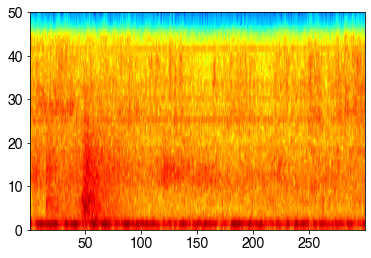

In [8]:
X_train_spec,Y_train_spec = load_multiple_spec(5000)
X_train_spec = np.swapaxes(X_train_spec,1,2)
Y_train_spec = np.expand_dims(Y_train_spec,axis=2)
print(X_train_spec.shape,Y_train_spec.shape)

In [ ]:
# train
model.fit(X_train_spec,Y_train_spec,epochs=50,batch_size=16)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
 912/5000 [====>.........................] - ETA: 6:56 - loss: 0.5931 - binary_crossentropy: 0.5931

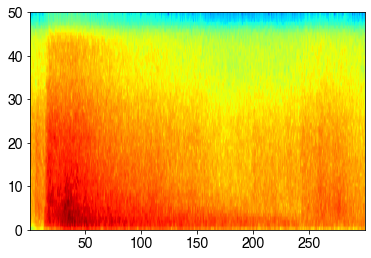

In [13]:
# plot predictions
X_pred_spec,Y_pred_spec = load_multiple_spec(10)
X_pred_spec = np.swapaxes(X_pred_spec,1,2)
#Y_pred_spec = np.swapaxes(Y_pred_spec,1,2)

In [28]:
spec_preds = model.predict(X_pred_spec)

In [15]:
spec_preds.shape

(10, 996, 1)

In [ ]:
plt.plot(spec_preds[8,:,:])

In [20]:
def plot_predictions(Y_pred,preds):
    """
    plot a random prediction
    """
    randint = np.random.randint(int(Y_pred.shape[0]))
    plt.plot(Y_pred[randint,:])
    plt.plot(preds[randint,:])
    
    

In [22]:
%matplotlib notebook

<IPython.core.display.Javascript object>


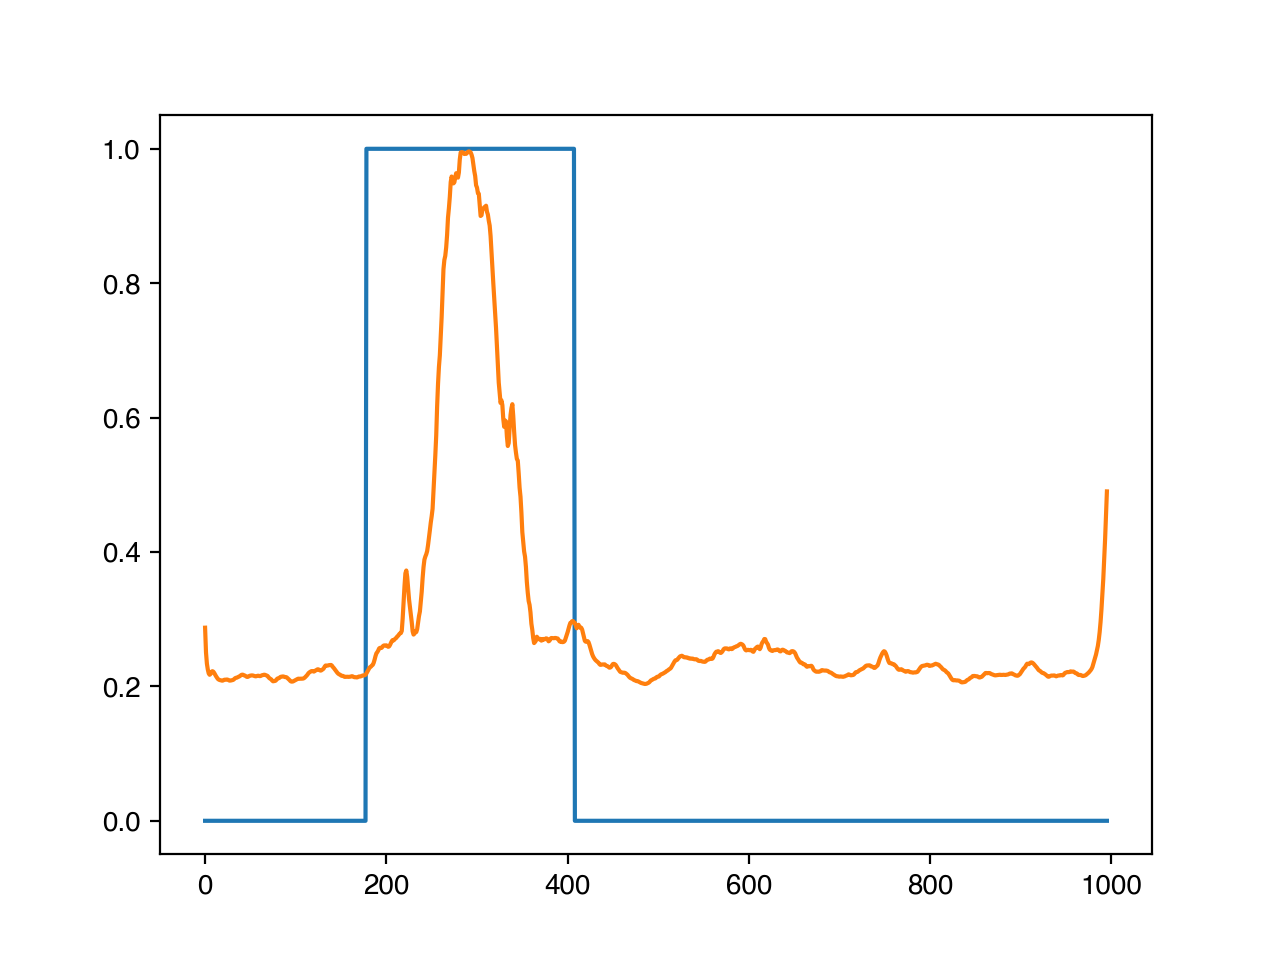

In [31]:
plot_predictions(Y_pred_spec,spec_preds)

In [ ]:
np.random.randint(5)